In [ ]:
# 导包
!pip install keras_tuner
import os
import json
import shutil
import numpy as np
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from matplotlib.font_manager import FontProperties
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import os
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 加载模型

In [ ]:
!wget https://github.com/CHATWA/MotherCup/releases/download/model/my_model_InceptionV3.keras

In [ ]:
!wget https://github.com/CHATWA/MotherCup/releases/download/weights/best_model.h5

In [ ]:
# 加载模型权重
from tensorflow.keras.models import load_model

model = load_model('my_model_InceptionV3.keras')
model.load_weights('best_model.h5')
# 打印模型的详细信息
model.summary()

# 模型评价

## 1.下载数据集

In [5]:
!git clone -b trian --single-branch https://github.com/CHATWA/MotherCup.git

Cloning into 'MotherCup'...
remote: Enumerating objects: 2105, done.
remote: Counting objects: 100% (1878/1878), done.
remote: Compressing objects: 100% (1869/1869), done.
remote: Total 2105 (delta 7), reused 1877 (delta 7), pack-reused 227
Receiving objects: 100% (2105/2105), 2.24 GiB | 34.48 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (1055/1055), done.


In [13]:
!os.chdir('MotherCup')

/bin/bash: -c: line 1: syntax error near unexpected token `'MotherCup''
/bin/bash: -c: line 1: `os.chdir('MotherCup')'


In [11]:
!ls -l

total 280300
-rw-r--r-- 1 root root 115384352 Nov  3 07:24 best_model.h5
drwxr-xr-x 4 root root      4096 Nov  3 10:34 MotherCup
-rw-r--r-- 1 root root 171628203 Nov  3 09:08 my_model_InceptionV3.keras
drwxr-xr-x 1 root root      4096 Nov  1 13:23 sample_data


## 2.评价

In [ ]:
from sklearn.metrics import classification_report

with open('./MotherCup/class_indices.json', 'r') as f:
  class_indices = json.load(f)

# 创建测试数据生成器并进行预处理
test_datagen = ImageDataGenerator(
  rescale=1 / 255
)

# 从目录加载测试数据并应用数据生成器
test_data = test_datagen.flow_from_directory(
  "./MotherCup/data/val",
  target_size=(299, 299),
  class_mode='sparse',
  shuffle=False,  # 不需要打乱样本顺序，因为我们要计算评估指标
  seed=1,
  classes=class_indices.keys()  # 加载自定义的类别编号映射
)

# 预测测试集
y_true = test_data.classes
y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob,axis=1)

# 计算评估指标
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))

# 计算分类报告
classification_rep = classification_report(y_true, y_pred, target_names=class_indices.keys())

print(f'Accuracy: {accuracy.numpy()}')
print(f'Classification Report:\n{classification_rep}')

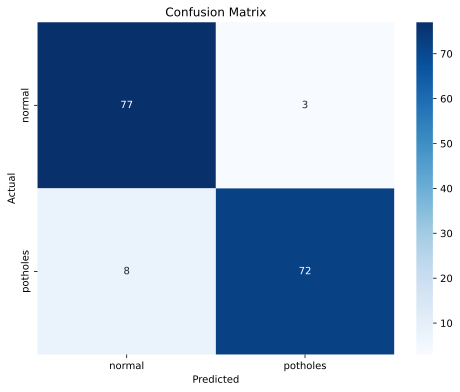

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 计算混淆矩阵
conf_mat = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices.keys(),
            yticklabels=class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Matrix.png')
plt.show()

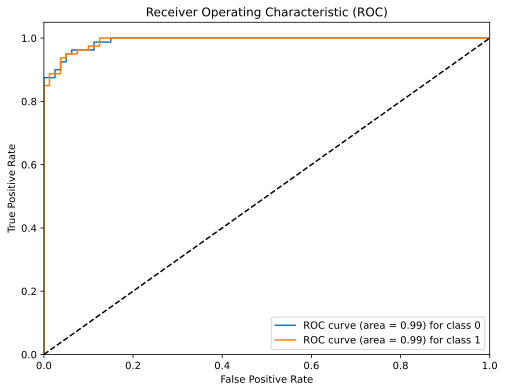

In [19]:
from sklearn.metrics import roc_curve, auc

# 计算每个类别的ROC曲线和AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for i in range(len(class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()

In [41]:
from sklearn.metrics import cohen_kappa_score
# 计算 Kappa 系数
kappa_score = cohen_kappa_score(y_true, y_pred)

print(f'Kappa 系数: {kappa_score}')

Kappa 系数: 0.8625


# 预测

## 1.下载数据集

In [24]:
!mkdir new
!os.chdir(r'./new')
!git clone -b prediction --single-branch https://github.com/CHATWA/MotherCup.git

/bin/bash: -c: line 1: syntax error near unexpected token `r'./new''
/bin/bash: -c: line 1: `os.chdir(r'./new')'
Cloning into 'MotherCup'...
remote: Enumerating objects: 6237, done.
remote: Counting objects: 100% (1345/1345), done.
remote: Compressing objects: 100% (1341/1341), done.
remote: Total 6237 (delta 2), reused 1344 (delta 2), pack-reused 4892
Receiving objects: 100% (6237/6237), 2.43 GiB | 28.96 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (4946/4946), done.


In [25]:
os.chdir(r'./MotherCup')

In [26]:
!ls -l

total 184
-rw-r--r-- 1 root root     35 Nov  3 10:53 class_indices.json
-rw-r--r-- 1 root root  34523 Nov  3 10:53 LICENSE
-rw-r--r-- 1 root root    456 Nov  3 10:53 rename.bat
drwxr-xr-x 2 root root 143360 Nov  3 10:53 testdata_V2


## 2.进行预测

In [28]:
class_names = ["potholes","normal"]

In [40]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

new_images_dir = "./testdata_V2"

# 获取new_images_dir目录下所有图片文件
image_files = [f for f in os.listdir(new_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# 从中随机选择30张图片
random_images = random.sample(image_files, 30)

# 设置子图的行数和列数
num_rows = 5
num_cols = 6

# 设置每个子图的大小
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 3, 3, 3, 3]})

# 遍历每张图片进行预测和显示
for i, image_name in enumerate(random_images):
    # 构建图片路径
    img_path = os.path.join(new_images_dir, image_name)

    # 加载图片
    img = image.load_img(img_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = img/255;
    img = np.expand_dims(img, axis=0)

    # 使用模型进行预测
    predictions = model.predict(img)
    class_probabilities = predictions[0]

    # 获取预测结果的类别编号和对应的概率
    predicted_class = np.argmax(class_probabilities)
    class_probability = class_probabilities[predicted_class]

    if predicted_class == 0:
        predicted_class = 1
    else:
        predicted_class = 0

    # 获取类别名称
    predicted_class_name = class_names[predicted_class]

    # 添加子图
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img[0])
    ax.set_title(f'{image_name}\n{predicted_class_name}\nProbability {class_probability:.4f}')
    ax.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 保存图像
plt.savefig('666.png')

# 显示图像
plt.show()

1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 210ms/step
[[0.6295936  0.37040636]]


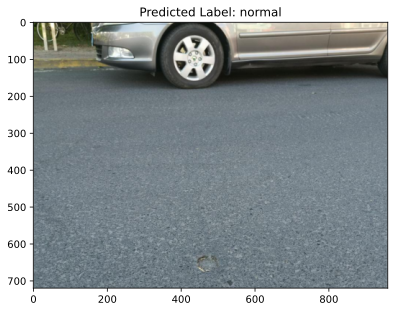

File: k5fsyb5g.jpg, Predicted Label: normal
1/1 [==============================] - 0s 220ms/step
[[0.00222732 0.99777263]]


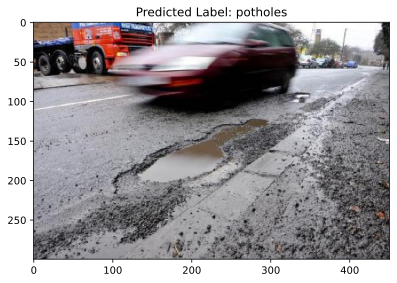

File: 9lds1sdq.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 223ms/step
[[0.74400735 0.2559926 ]]


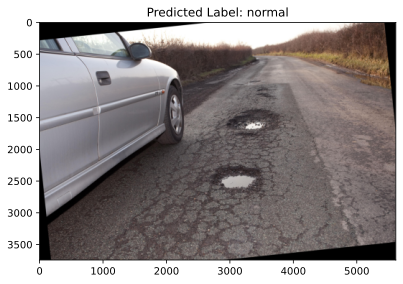

File: 6a0543bo.jpg, Predicted Label: normal
1/1 [==============================] - 0s 225ms/step
[[2.9611826e-04 9.9970382e-01]]


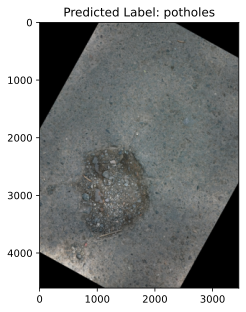

File: hzgaliaq.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 221ms/step
[[7.092073e-05 9.999291e-01]]


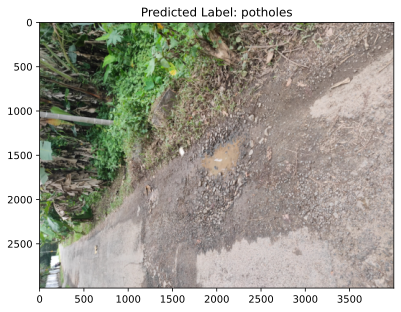

File: pwrmd3qf.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 268ms/step
[[0.99810326 0.00189672]]


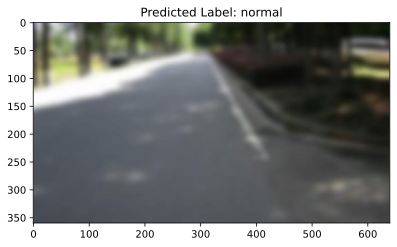

File: cln5m1s7.jpg, Predicted Label: normal
1/1 [==============================] - 0s 229ms/step
[[2.1469667e-04 9.9978536e-01]]


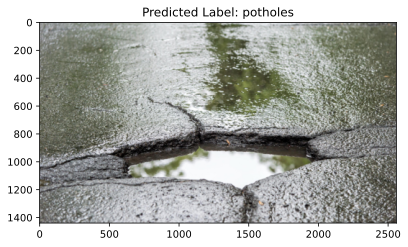

File: mbjzv4ol.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 282ms/step
[[4.3532393e-05 9.9995649e-01]]


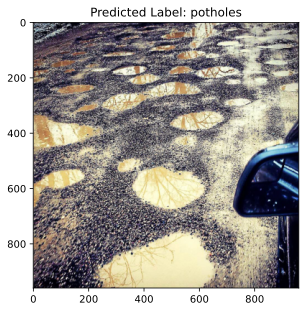

File: hxx1zfab.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 258ms/step
[[4.2937952e-04 9.9957067e-01]]


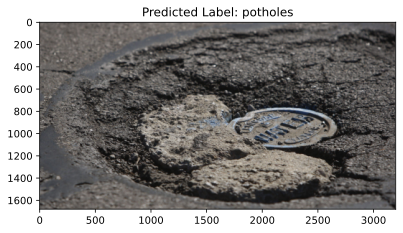

File: ybxaosw0.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 265ms/step
[[3.6474963e-04 9.9963522e-01]]


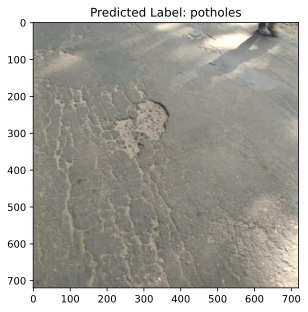

File: ukol3tuc.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 270ms/step
[[0.00101054 0.9989894 ]]


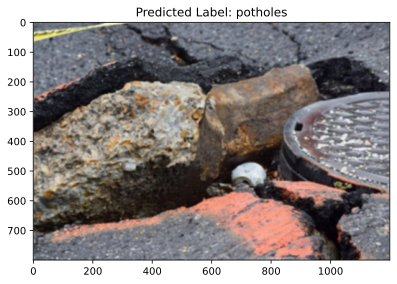

流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 241ms/step
[[0.00271402 0.99728596]]
File: xieg2gmt.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 306ms/step
[[0.96012706 0.03987293]]
File: t3axd5u3.jpg, Predicted Label: normal
1/1 [==============================] - 0s 275ms/step
[[0.01833541 0.98166466]]
File: fb7iasiz.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 264ms/step
[[0.977727   0.02227298]]
File: 6uc6w3n1.jpg, Predicted Label: normal
1/1 [==============================] - 0s 318ms/step
[[2.6473219e-05 9.9997354e-01]]
File: uhxk0ekh.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 325ms/step
[[0.00110081 0.9988992 ]]
File: 583sjho4.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 419ms/step
[[1.4081031e-04 9.9985921e-01]]
File: aq10ek4z.jpg, Predicted Label: potholes
1/1 [==============================] - 0s 390ms/step
[[0.9983583  0.00164165]]
File: d373c

In [ ]:
# 新图片的目录
new_images_dir = "./testdata_V2"

# 获取新图片文件名列表
new_image_files = os.listdir(new_images_dir)

# 创建一个空的DataFrame来保存结果
result_df = pd.DataFrame(columns=['fnames', 'label'])

# 设定要显示的图片数量
num_images_to_display = 10
displayed_images = 0

# 对每张新图片进行预测
for fname in new_image_files:
  # 生成图片的完整路径
  img_path = os.path.join(new_images_dir, fname)

  try:
    # 加载图片
    img = image.load_img(img_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = img/255;
    img = np.expand_dims(img, axis=0)

    # 使用模型进行预测
    prediction = model.predict(img)
    print(prediction)
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    if predicted_label == 0:
      predicted_label = 1;
    else:
      predicted_label = 0;

    # 将结果添加到DataFrame中
    result_df = pd.concat([result_df, pd.DataFrame({'fnames': [fname], 'label': [predicted_label]})], ignore_index=True)

    # 显示图片
    if displayed_images <= num_images_to_display:
      plt.imshow(image.load_img(img_path))
      plt.title(f'Predicted Label: {class_names[predicted_label]}')
      plt.show()

    # 打印文件名和预测类别
    print(f'File: {fname}, Predicted Label: {class_names[predicted_label]}')

    # 增加已显示图片的计数器
    displayed_images += 1
  except Exception as e:
    # 发生异常时打印错误信息和文件名，并继续处理下一个文件
    print(f'Error processing file {fname}: {str(e)}')
    continue

# 保存结果为CSV文件
result_df.to_csv('predictions.csv', index=False)